In [4]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
    --------------------------------------- 0.5/39.5 MB 4.2 MB/s eta 0:00:10
   ----- ---------------------------------- 5.5/39.5 MB 19.8 MB/s eta 0:00:02
   --------------- ------------------------ 15.5/39.5 MB 32.4 MB/s eta 0:00:01
   ------------------------ --------------- 23.9/39.5 MB 37.7 MB/s eta 0:00:01
   ------------------------------ --------- 29.9/39.5 MB 33.3 MB/s eta 0:00:01
   ----------------------------------- ---- 35.1/39.5 MB 32.3 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.5 MB 31.7 MB/s eta 0:00:01
   ---------------------------------------- 39.5/39.5 MB 30.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Epoch 1/50
119/119 [==============================] - 83s 557ms/step - loss: 0.0417 - accuracy: 0.6531 - val_loss: 0.0770 - val_accuracy: 0.8424
Epoch 2/50
119/119 [==============================] - 82s 689ms/step - loss: 0.0329 - accuracy: 0.7102 - val_loss: 0.0903 - val_accuracy: 0.8076
Epoch 3/50
119/119 [==============================] - 45s 377ms/step - loss: 0.0320 - accuracy: 0.7181 - val_loss: 0.0949 - val_accuracy: 0.7869
Epoch 4/50
119/119 [==============================] - 44s 374ms/step - loss: 0.0320 - accuracy: 0.7219 - val_loss: 0.0872 - val_accuracy: 0.8090
Epoch 5/50
119/119 [==============================] - 45s 376ms/step - loss: 0.0326 - accuracy: 0.7171 - val_loss: 0.0749 - val_accuracy: 0.7702
Epoch 6/50
119/119 [==============================] - 44s 371ms/step - loss: 0.0314 - accuracy: 0.7236 - val_loss: 0.0928 - val_accuracy: 0.7943
Epoch 7/50
119/119 [==============================] - 45s 378ms/step - loss: 0.0291 - accuracy: 0.7310 - val_loss: 0.0788 - val_ac

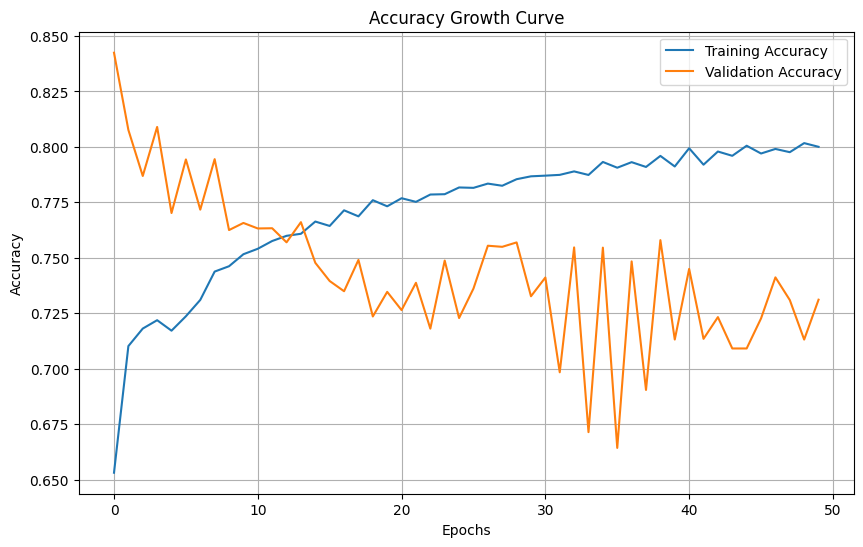

In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2DTranspose
import cv2  
from PIL import UnidentifiedImageError
import shutil
from sklearn.model_selection import train_test_split
raw_images_dir = './input'
raw_labels_dir = './label'

train_images_dir = './train_split/input'
train_labels_dir = './train_split/label'
val_images_dir = './val_split/input'
val_labels_dir = './val_split/label'


# 建立資料夾
for folder in [train_images_dir, train_labels_dir, val_images_dir, val_labels_dir]:
    os.makedirs(folder, exist_ok=True)

# 排除 .DS_Store，取得檔名交集
all_filenames = sorted([
    f for f in os.listdir(raw_images_dir)
    if f.endswith('.jpg') and os.path.exists(os.path.join(raw_labels_dir, f))
])


# 分割資料
train_filenames, val_filenames = train_test_split(all_filenames, test_size=0.2, random_state=42)

# 複製檔案到新位置
for fname in train_filenames:
    shutil.copy(os.path.join(raw_images_dir, fname), os.path.join(train_images_dir, fname))
    shutil.copy(os.path.join(raw_labels_dir, fname), os.path.join(train_labels_dir, fname))

for fname in val_filenames:
    shutil.copy(os.path.join(raw_images_dir, fname), os.path.join(val_images_dir, fname))
    shutil.copy(os.path.join(raw_labels_dir, fname), os.path.join(val_labels_dir, fname))

train_input_dir = './train_split/input'
train_label_dir = './train_split/label'
test_input_dir = './train_split/input'

output_dir = './output'


# 確保輸出資料夾存在
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 設定參數
batch_size = 64  # 增加批次大小
epochs = 50  # 增加訓練週期
n_channels = 3  # 使用3個通道

# 計算步數
num_train_samples = len(os.listdir(train_input_dir))
num_test_samples = len(os.listdir(test_input_dir))
steps_per_epoch = int(np.ceil(num_train_samples / batch_size))
validation_steps = int(np.ceil(num_test_samples / batch_size))

# 創建資料生成器，設置rescale和target_size為178x218
datagen = ImageDataGenerator(rescale=1./255)

def expand_to_n_channels(image, n_channels):
    if image.shape[-1] == n_channels:
        return image
    return np.repeat(image, n_channels // image.shape[-1], axis=-1)

def custom_flow_from_directory_no_classes(directory, target_size=(218, 178), batch_size=32, n_channels=3):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    while True:
        for start in range(0, len(filepaths), batch_size):
            x_batch = []
            end = min(start + batch_size, len(filepaths))
            for filepath in filepaths[start:end]:
                try:
                    image = load_img(filepath, target_size=target_size)
                except UnidentifiedImageError:
                    print(f"未識別的圖片文件: {filepath}, 跳過.")
                    continue
                image_array = img_to_array(image) / 255.0
                image_array = expand_to_n_channels(image_array, n_channels)
                x_batch.append(image_array)
            if not x_batch:
                continue  # 如果沒有有效圖片，跳過該批次
            x_batch = np.array(x_batch)
            yield x_batch, x_batch  # 返回 (inputs, targets)

def custom_combined_generator(input_dir, label_dir, target_size=(218, 178), batch_size=32, n_channels=3):
    input_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir)]
    label_paths = [os.path.join(label_dir, fname) for fname in os.listdir(label_dir)]
    
    while True:
        for start in range(0, len(input_paths), batch_size):
            input_batch = []  # 在每個批次開始時初始化列表
            label_batch = []  # 在每個批次開始時初始化列表
            end = min(start + batch_size, len(input_paths))
            for input_path, label_path in zip(input_paths[start:end], label_paths[start:end]):
                try:
                    input_image = load_img(input_path, target_size=target_size)
                except UnidentifiedImageError:
                    print(f"未識別的圖片文件: {input_path}, 跳過.")
                    continue
                input_array = img_to_array(input_image) / 255.0
                input_array = expand_to_n_channels(input_array, n_channels)
                input_batch.append(input_array)
                
                try:
                    label_image = load_img(label_path, target_size=target_size)
                except UnidentifiedImageError:
                    print(f"未識別的圖片文件: {label_path}, 跳過.")
                    continue
                label_array = img_to_array(label_image) / 255.0
                label_array = expand_to_n_channels(label_array, n_channels)
                label_batch.append(label_array)
                
            if not input_batch or not label_batch:
                continue  # 如果沒有有效圖片，跳過該批次
            input_batch = np.array(input_batch)
            label_batch = np.array(label_batch)
            yield input_batch, label_batch  # 返回 (inputs, targets)

train_generator = custom_combined_generator(train_input_dir, train_label_dir, target_size=(218, 178), n_channels=n_channels)
test_generator = custom_flow_from_directory_no_classes(test_input_dir, target_size=(218, 178), n_channels=n_channels)

def unet_model(input_size=(218, 178, 3)):
    inputs = Input(input_size)

    # 編碼器
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)

    # 解碼器
    up6 = Conv2DTranspose(512, 3, strides=(2, 2), padding='same')(conv5)
    if up6.shape[1] < conv4.shape[1] or up6.shape[2] < conv4.shape[2]:
        up6 = ZeroPadding2D(((0, conv4.shape[1] - up6.shape[1]), (0, conv4.shape[2] - up6.shape[2])))(up6)

    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)

    up7 = Conv2DTranspose(256, 3, strides=(2, 2), padding='same')(conv6)
    if up7.shape[1] < conv3.shape[1] or up7.shape[2] < conv3.shape[2]:
        up7 = ZeroPadding2D(((0, conv3.shape[1] - up7.shape[1]), (0, conv3.shape[2] - up7.shape[2])))(up7)

    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)

    up8 = Conv2DTranspose(128, 3, strides=(2, 2), padding='same')(conv7)
    if up8.shape[1] < conv2.shape[1] or up8.shape[2] < conv2.shape[2]:
        up8 = ZeroPadding2D(((0, conv2.shape[1] - up8.shape[1]), (0, conv2.shape[2] - up8.shape[2])))(up8)

    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)

    up9 = Conv2DTranspose(64, 3, strides=(2, 2), padding='same')(conv8)
    if up9.shape[1] < conv1.shape[1] or up9.shape[2] < conv1.shape[2]:
        up9 = ZeroPadding2D(((0, conv1.shape[1] - up9.shape[1]), (0, conv1.shape[2] - up9.shape[2])))(up9)

    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

# 訓練模型
with tf.device("/GPU:0"):
    model = unet_model(input_size=(218, 178, 3))
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=validation_steps
    )

    # ✅ 訓練完儲存模型
    model.save('Beauty_unet_model.keras')
    print("✅ 模型已儲存為 unet_model.keras")

# 保存預測
def predict_and_save(image_path, model, output_path):
    image = load_img(image_path, target_size=(218, 178))  # 設置target_size
    image_array = img_to_array(image) / 255.0  # 標準化預測數據
    image_array = np.expand_dims(image_array, axis=0)

    with tf.device("/GPU:0"):
        prediction = model.predict(image_array)
        
    prediction = prediction[0] * 255  # 恢復原始數值範圍，選擇第一個樣本
    prediction = np.round(prediction).astype(np.uint8)  # 取整數

    # 使用OpenCV保存圖片
    output_image_path = os.path.join(output_path, os.path.basename(image_path))
    cv2.imwrite(output_image_path, cv2.cvtColor(prediction, cv2.COLOR_RGB2BGR))

# 迭代所有測試資料夾中的圖片並保存預測
for filename in os.listdir(test_input_dir):
    image_path = os.path.join(test_input_dir, filename)
    predict_and_save(image_path, model, output_dir)

# 保存預測結果到CSV文件
def save_predictions_to_csv(output_dir, csv_path):
    results = []

    # 排序以確保索引一致性
    file_list = sorted(os.listdir(output_dir))
    for index, filename in enumerate(file_list):
        image_path = os.path.join(output_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 確保使用RGB
            flattened_image = image.flatten()  # 將圖片數據展平為一維數組
            results.append([index] + flattened_image.tolist())  # 添加索引和圖片數據
        else:
            print(f"警告: 無法讀取圖片 {image_path}, 跳過.")

    # 創建DataFrame
    if results:
        num_columns = len(results[0]) - 1  # 減掉索引列
        columns = ['index'] + [str(i) for i in range(num_columns)]
        df = pd.DataFrame(results, columns=columns)
        df.to_csv(csv_path, index=False)
    else:
        print("未找到有效圖片.")

# 設定CSV文件路徑
csv_path = 'submission.csv'
save_predictions_to_csv(output_dir, csv_path)

# 繪製準確率圖表
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Growth Curve')
plt.legend()
plt.grid(True)

# 保存準確率圖表
plt.savefig('accuracy_growth_curve.png')
plt.show()

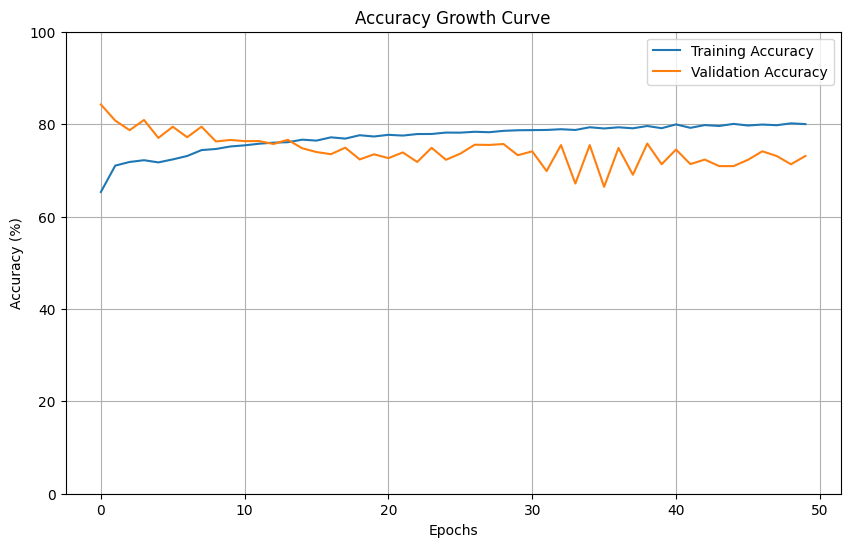

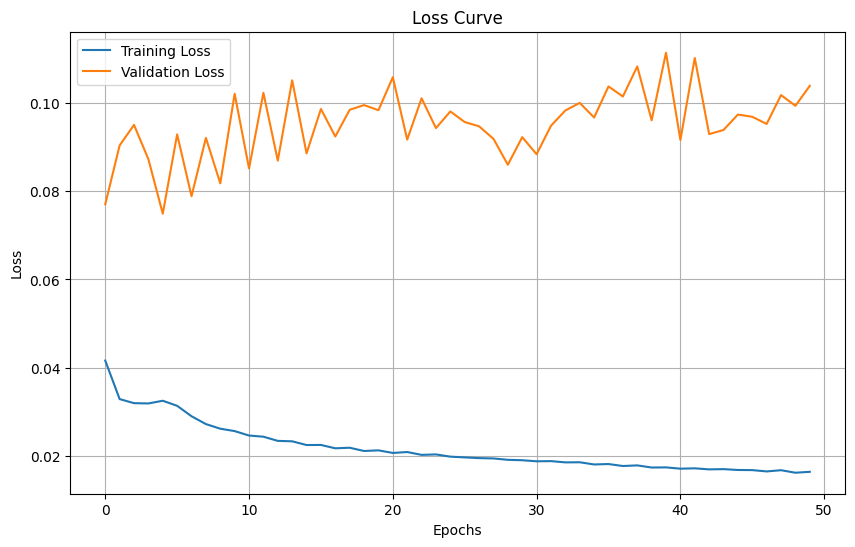

In [2]:
# 繪製準確率圖表（百分比形式）
plt.figure(figsize=(10, 6))
plt.plot(np.array(history.history['accuracy']) * 100, label='Training Accuracy')
plt.plot(np.array(history.history['val_accuracy']) * 100, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Growth Curve')
plt.ylim(0, 100)  # 設定Y軸從0到100
plt.legend()
plt.grid(True)

# 儲存圖表
plt.savefig('accuracy_growth_curve.png')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# 保存 loss 圖
plt.savefig('loss_curve.png')
plt.show()
